In [1]:
import pandas as pd

file_path = 'extended-log.csv'

# Einlesen der Datei
df = pd.read_csv(file_path, sep='\t', header=None, names=[
    'Zeit_Index',
    'X_GT', 'Y_GT',
    'Heading_GT', 'Heading', 'Heading_STD',
    'angle_GT_B0', 'angleDistorted_B0', 'STD_angle_B0',
    'angle_GT_B1', 'angleDistorted_B1', 'STD_angle_B1',
    'angle_GT_B2', 'angleDistorted_B2', 'STD_angle_B2',
    'Richtung_GT_X_B0', 'Richtung_GT_Y_B0',
    'Richtung_X_B0', 'Richtung_Y_B0', 'STD_Richtung_B0',
    'Richtung_GT_X_B1', 'Richtung_GT_Y_B1',
    'Richtung_X_B1', 'Richtung_Y_B1', 'STD_Richtung_B1',
    'Richtung_GT_X_B2', 'Richtung_GT_Y_B2',
    'Richtung_X_B2', 'Richtung_Y_B2', 'STD_Richtung_B2',
    'Entfernung_B0', 'EntfernungDistorted_B0', 'STD_Entfernung_B0',
    'Entfernung_B1', 'EntfernungDistorted_B1', 'STD_Entfernung_B1',
    'Entfernung_B2', 'EntfernungDistorted_B2', 'STD_Entfernung_B2'
])

#print(df.head())
df

,Zeit_Index,X_GT,Y_GT,Heading_GT,Heading,Heading_STD,angle_GT_B0,angleDistorted_B0,STD_angle_B0,angle_GT_B1,...,STD_Richtung_B2,Entfernung_B0,EntfernungDistorted_B0,STD_Entfernung_B0,Entfernung_B1,EntfernungDistorted_B1,STD_Entfernung_B1,Entfernung_B2,EntfernungDistorted_B2,STD_Entfernung_B2
0,0,0.000000,-14.86000,0.00000,0.302768,1,153.65050,152.00870,1,90.00120,...,1,33.47864,34.21057,1,44.86000,45.09378,1,33.47864,33.95691,1
1,1,0.000005,-14.76000,0.00000,1.706519,1,153.80870,154.49400,1,90.00588,...,1,33.43438,31.69575,1,44.75999,45.07170,1,33.43437,32.76717,1
2,2,0.000020,-14.61999,0.00000,0.841136,1,154.02510,153.48720,1,90.00665,...,1,33.37282,32.21387,1,44.62000,45.33285,1,33.37279,33.08078,1
3,3,0.000032,-14.51968,0.00000,-1.247449,1,154.18050,155.50460,1,90.00697,...,1,33.32901,32.69810,1,44.51968,44.76485,1,33.32896,32.05080,1
4,4,0.000045,-14.41456,0.00000,-0.357731,1,154.34370,155.81920,1,90.00729,...,1,33.28336,32.72014,1,44.41456,45.18420,1,33.28328,33.74501,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,114,-8.551874,71.89081,16.14644,16.741090,1,-90.46567,-88.98692,1,-62.31535,...,1,75.02206,77.02315,1,42.75482,41.15388,1,81.57533,82.89262,1
115,115,-8.218143,73.04346,16.14945,15.375360,1,-90.45535,-89.80869,1,-63.04134,...,1,76.22202,74.72125,1,43.82096,45.44051,1,82.43769,82.42320,1
116,116,-7.939984,74.00400,16.15183,13.661690,1,-90.44708,-90.42654,1,-63.61990,...,1,77.22199,77.00272,1,44.71460,44.93034,1,83.16270,83.47511,1
117,117,-7.661776,74.96452,16.15364,16.718780,1,-90.43958,-90.66087,1,-64.17627,...,1,78.22196,79.79951,1,45.61261,45.34606,1,83.89331,82.47662,1


In [2]:

"""
UKF mit Entfernung.
"""

# Imports
import numpy as np
import matplotlib.pyplot as plt
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import math
from math import sin as sin
from math import cos as cos
import time
import pandas as pd


# Konfigurationsvariablen
STD_BEACONS = np.array([0.1, 0.1, 0.1])  # Standardabweichung für Beacons
BEACON_POSITIONS = [np.array([-30, 0]), np.array([0, 30]), np.array([30, 0])]
dT = 0.1 # 10 hz => 100ms
MODE = "Manual"  # Setzen ob statische Daten (Manual) oder Lesen aus Log-Datei (LogReadIn)
#MODE = "LogReadIn"


def f_x(state, dt):
    """
    Zustandsübergangsfunktion.
    Da die Geschwindigkeit konstant ist und der Zustand nur die Position beinhaltet,
    hat diese Funktion einfach die Geschwindigkeit zur Position hinzugefügt.
    """  
    x, y, vx, vy, ax, ay = state

    # Update position with current velocity and acceleration
    new_x = x + vx * dt + (ax * dt ** 2) / 2.0
    new_y = y + vy * dt + (ay * dt ** 2) / 2.0

    # Update velocity with current acceleration
    new_vx = vx + ax * dt
    new_vy = vy + ay * dt

    # Speed stays constant (no acceleration yet)
    new_ax = ax
    new_ay = ay

    return np.array([new_x, new_y, new_vx, new_vy, new_ax, new_ay])


def h_x(state):
    """
    Messfunktion.
    """ 
    # Position des Schiffs extrahieren
    # x, y, vx, vy, _, _ = state
    x, y = state[0], state[1]
    
    distances = []

    # Für alle Beacons 
    for beacon_pos in BEACON_POSITIONS:
        # Euklidische Distanz (Pythagoras): d = sqrt((x2 - x1)**2 + (y2 - y1) **2)
        distance = np.sqrt((beacon_pos[0] - x) ** 2 + (beacon_pos[1] - y) ** 2)
        
        distances.append(distance)
    
    # Bei drei Beacons: array([d1, d2, d3])
    return np.array(distances)


def init_ukf():
    """
    Initialisierung vom UKF.
    """
    sigmas = MerweScaledSigmaPoints(n=6, alpha=0.1, beta=2.0, kappa=1.0)
    # Dim_z 3, da 3 (ein Vektor; 3 Elementen) separate Messungen von h_x zurück gegeben werden
    ukf = UKF(dim_x=6, dim_z=3, fx=f_x, hx=h_x, dt=dT, points=sigmas)

    init_state = np.array([0, -14.9, 0, 1, 0, 0])  # [x, y, vx, vy, ax, ay] 
    ukf.x = init_state
    
    ukf.Q = Q_discrete_white_noise(dim=2, dt=dT, var=2.0, block_size=3, order_by_dim=False)
    # Später dynamisch in Schleife
    
    return ukf


def create_ship_movement(steps, dt):
    """
    Simulierung der Bewegung des Schiffs (für gegebene Anzahl an Einheiten/Schritten).
    """
    return [np.array([5 * math.sin(i * dt), -10 + 2 * i * dt, 0, 1, 0, 0]) for i in range(steps)]



def create_noisy_measurements(states):
    """
    Erzeugt verrauschte Messdaten basierend auf wahren Zustände (richtige Schiffsbewegungen).
    """
    np.random.seed(int(time.time()))
    return [h_x(state) + np.random.normal(0, STD_BEACONS) for state in states]


if __name__ == "__main__":

    """
    MODE jeweils im Header setzen.
    """
    
    if MODE == "Manual":
        
        # Erstellung 1000 Schritte Schiffsbewegung
        states = create_ship_movement(1000, dT)
    
        # Rauschdaten erzeugen
        zs = create_noisy_measurements(states)
    
        # Init UKF.
        ukf = init_ukf()
        # ukf.x = states[0].copy() #  passiert bereits in init_ukf-Funktion
        
        # Einmaliges Setzen von R
        ukf.R = np.diag(STD_BEACONS ** 2)
    
        # Liste für gefiterte Zustände
        uxs = []
    
        # Leere Liste für Kovarianzmatrizen P für jede Iteration (Unsicherheit der Schätzung relativ zur Zeit)
        uPs = []
        
        # Schleife für UKF
        for z in zs:
            
            ukf.predict()
            ukf.update(z)
        
            uxs.append(ukf.x.copy())
            uPs.append(ukf.P.copy())
    
        # Gefilterte Zustände [x, y, vx, vy, ax, ay]
        uxs = np.array(uxs)
    
        # States (Bewegungen)
        states = np.array(states)

    elif MODE == "LogReadIn":

        # Speichere geschätzten Zustände und Kovarianzmatrizen
        uxs = []
        uPs = []

        # Init UKF.
        ukf = init_ukf()

        # Initial Zustand fix im Code vs. aus dem ersten Log
        # ukf.x = initial_state  #  passiert bereits in init_ukf-Funktion
        
        # Iteriere durch jede Zeile im Df
        for index, row in df.iterrows():
        
            # Standardabweichungen für die aktuelle Messung aus Spalte holen
            # Wichtig: Nochmal Division-Faktor anschauen
            std_b0 = row['STD_Entfernung_B0'] / 10
            std_b1 = row['STD_Entfernung_B1'] / 10
            std_b2 = row['STD_Entfernung_B2'] / 10
        
            # Zeige Std zwecks Korrektheit
            #print(std_b0, std_b1, std_b2)
            
            # Setze die Rauschmatrix R basierend auf den extrahierten Standardabweichungen immer neu
            ukf.R = np.diag([std_b0 ** 2, std_b1 ** 2, std_b2 ** 2])
        
            # Prüfe ob Std. in R-Matrix gesetzt werden
            # print(ukf.R)
            
            # Extrahiere den aktuellen Messvektor z
            z = np.array([
                row['EntfernungDistorted_B0'],
                row['EntfernungDistorted_B1'],
                row['EntfernungDistorted_B2'],
            ])
        
            # Check ob Daten korrekt eingelesen sind
            # print(z)
            
            # Vorhersage und Update mit dem aktuellen Messvektor
            ukf.predict()
            ukf.update(z)
        
            uxs.append(ukf.x.copy())
            uPs.append(ukf.P.copy())
    
        # Gefilterte Zustände [x, y, vx, vy, ax, ay]
        uxs = np.array(uxs)

In [3]:
print (uxs)

#print(states)

[[ 1.06975525e-01 -1.02036513e+01  1.06443947e-02  1.45733106e+00
   5.29571909e-04  2.27527803e-02]
 [ 3.56027636e-01 -9.81844486e+00  1.54803549e+00  2.83822083e+00
   2.39243677e-01  2.20592258e-01]
 [ 8.16860253e-01 -9.63726544e+00  3.27146918e+00  2.31612364e+00
   6.80837061e-01  9.12756346e-02]
 ...
 [-4.30927974e+00  1.89458186e+02  1.91793391e+00  2.23504655e+00
   3.73541072e+00  2.62392432e-01]
 [-3.82347549e+00  1.89619949e+02  2.70628396e+00  2.00769462e+00
   4.04392669e+00  6.99684953e-02]
 [-3.45731224e+00  1.89769377e+02  3.23028826e+00  1.81481210e+00
   4.13513294e+00 -8.31012264e-02]]


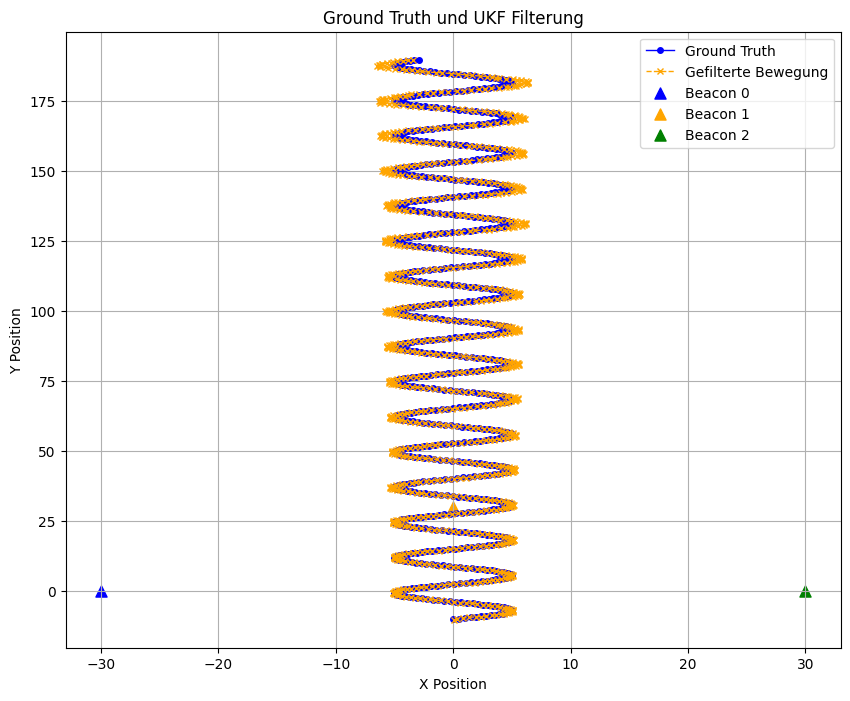

In [6]:
# Wichtig: Scatter statt Plot verwenden falls keine Verbindungslinien gezeichnet werden sollen!

def plotte_gt_and_estimate(gt_x, gt_y, x_esti, y_esti, beacons, title='Ground Truth und UKF Filterung'):
    
    plt.figure(figsize=(10, 8))
    
    # Plot Ground Truth und geschätzte Position
    plt.plot(gt_x, gt_y, 'b-', label='Ground Truth', marker='o', markersize=4, linewidth=1)
    plt.plot(x_esti, y_esti, label='Gefilterte Bewegung', marker='x', markersize=4, linewidth=1, linestyle='--', color='orange')
    
    # Farben für die Beacons
    beacon_colors = ['blue', 'orange', 'green']
    
    # Beacons
    for i, beacon in enumerate(beacons):
        plt.scatter(beacon[0], beacon[1], s=64, color=beacon_colors[i], label=f'Beacon {i}', marker='^')

    
    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    
    plt.legend()
    
    plt.grid(True)
    plt.show()


# BEACON_POSITIONS muss als Liste von [x, y] Koordinaten definiert sein
beacons_xy = [[beacon[0], beacon[1]] for beacon in BEACON_POSITIONS]


ux_val = [s[0] for s in uxs]
uy_val = [s[1] for s in uxs]

if MODE == "Manual":
    gt_x = [state[0] for state in states]
    gt_y = [state[1] for state in states]
elif MODE == "LogReadIn":
    gt_x = df['X_GT'].tolist()
    gt_y = df['Y_GT'].tolist()

plotte_gt_and_estimate(gt_x, gt_y, ux_val, uy_val, beacons_xy)


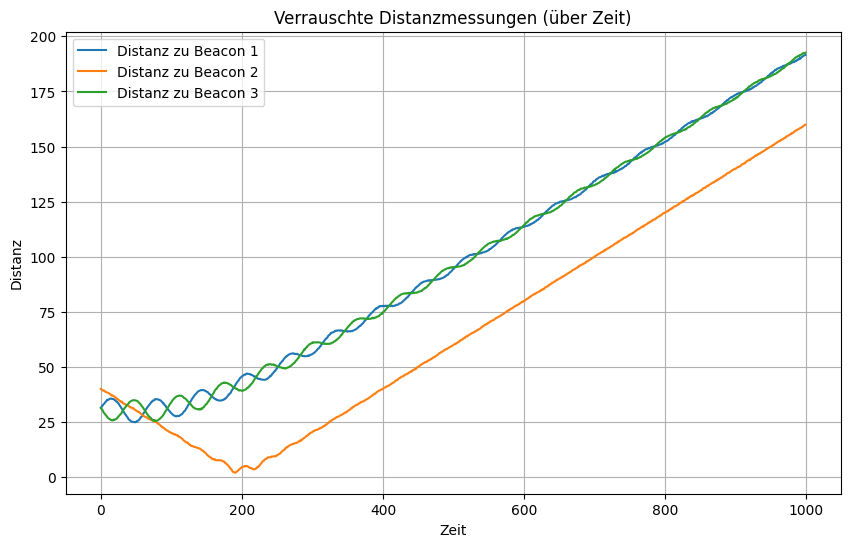

In [5]:

def plotte_noisy_distances(time_steps, noisy_distances):
    
    plt.figure(figsize=(10, 6))
    
    for i in range(noisy_distances.shape[1]):
        plt.plot(time_steps, noisy_distances[:, i], label=f'Distanz zu Beacon {i+1}')
    
    plt.title('Verrauschte Distanzmessungen (über Zeit)')
    plt.xlabel('Zeit')
    plt.ylabel('Distanz')
    
    plt.legend()
    
    plt.grid(True)
    plt.show()

if MODE == "Manual":
    # zs haz verrauschten Distanzmessungen zu den Beacons
    # dh. Zeit relativ zur Länge der verrauschten Messungen
    time_steps = range(len(zs))
    noisy_distances = np.array(zs)

elif MODE == "LogReadIn":
    # df enthältverrauschten Distanzmessungen zu den Beacons in separaten Spalten
    # dh.Zeit relativ zum Index der Datei
    time_steps = df.index
    noisy_distances = df[['EntfernungDistorted_B0', 'EntfernungDistorted_B1', 'EntfernungDistorted_B2']].values

plotte_noisy_distances(time_steps, noisy_distances)